In [108]:
import math
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as dist
from scipy.optimize import minimize
from scipy.stats import norm



'''Surrogate Model Init and its Functions'''

class SurrogateModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y,likelihood):
        super(SurrogateModel, self).__init__(train_x,train_y,likelihood)
        self.mean = gpytorch.means.ConstantMean()

        #use ScaleKernel() to introduce variance hyperparameter
        self.covar = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean(x)
        covar = self.covar(x)
        return gpytorch.distributions.MultivariateNormal(mean,covar)


def train(model, train_x, train_y, training_iter,  lr = .001):
    
    
    model.train() #this doesn't actually train it just sets the surrogate into training mode
    model.likelihood.train()

    #this initializes Adam to optimize variance and lengthscale of RBF kernel to minimize
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    for i in range(training_iter):
        
        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Outputs (size of train_x) number multivariate distributions
        output = model(train_x)
        
        # Measures how well the GP fits the observed data
        loss = -mll(output, train_y) 
        loss.backward()

        optimizer.step()

def predict(model, xaxis):
    """
    Make predictions with the trained GP model at new points.
    
    :param model: The trained Gaussian Process model.
    :param xaxis: Tensor of input points at which to make predictions.
    :return: mean and standard deviation of the GP at the given points.
    """
    model.eval()  # Set the model in evaluation mode
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Make predictions
        observed_pred = model(xaxis)
        mean = observed_pred.mean
        stddev = observed_pred.stddev
    return mean,stddev

'''Acquisition Functions'''

def ucb(model, xaxis, train_y, epsilon):
    mean, stdev = predict(model, xaxis)
    ucb_value = mean + epsilon * stdev
    return xaxis[torch.argmax(ucb_value)]

def poi(model,xaxis,train_y, epsilon):

    best_value = torch.max(train_y)
    mean, stdev = predict(model,xaxis)

    z = (mean - best_value - epsilon) / (stdev + 1e-9)
    PI = dist.Normal(0,1).cdf(z)

    return xaxis[torch.argmax(PI)]


def ei(model,xaxis, train_y, epsilon):

    best_value = torch.max(train_y)
    mean, stdev = predict(model, xaxis)

    z = (mean - best_value - epsilon) / (stdev + 1e-9)  # Avoid division by zero
    normal = dist.Normal(0, 1)

    expected_improvement = (mean - best_value - epsilon) * normal.cdf(z) + stdev * normal.log_prob(z).exp()
    return xaxis[torch.argmax(expected_improvement)]


'''Different Bayesian Optimization Functions'''

def bayesian_optimization(model, xaxis, train_x, train_y, acquisition_function, epsilon, n_iter):
    

    for iteration in range(n_iter):

        # Select next sample using the chosen acquisition function
        next_sample = acquisition_function(model, xaxis, train_y, epsilon)
        next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)  # Example objective function

        # Update training data
        train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
        train_y = torch.cat([train_y, next_y.unsqueeze(0)])

        # Update model with new training data
        model.set_train_data(train_x, train_y, strict=False)

        # Retrain the model (this changes the lengthscale and variance hyperparameters)
        train(model, train_x, train_y, training_iter=50, lr=0.001)

        #change the mean and standard deviation with the trained model and new sample data
        mean, stddev = predict(model, xaxis)

        # Plot results
        plt.plot(xaxis.numpy(), ground_truth.numpy(), 'k', label='Ground Truth')
        plt.plot(xaxis.numpy(), mean.numpy(), 'b', label='Predicted Mean')
        plt.fill_between(xaxis.numpy(), (mean + 1.96 * stddev).numpy(), (mean - 1.96 * stddev).numpy(), alpha=0.3, color='blue', label='Confidence Interval (95%)')
        plt.scatter(train_x.numpy(), train_y.numpy(), color='r', zorder=10, label='Training Data')
        plt.title(f'Bayesian Optimization Iteration: {iteration+1}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()
        
"""Optimizing Epsilon Section"""

def optimize_acquisition1(acquisition_function, xaxis, ground_truth, n_runs=100, 
                        epsilon_range=(0.01, 2.0), n_epsilons=10, n_iter=5, tolerance=0.05):
    """
    Optimize the epsilon value for an acquisition function based on proximity to the x-value of the global maximum.
    
    :param acquisition_function: The acquisition function to test (e.g., ei, poi, ucb).
    :param xaxis: Tensor of input points for predictions.
    :param ground_truth: Tensor of the ground truth function values.
    :param n_runs: Number of Bayesian optimization runs per epsilon (default: 100).
    :param epsilon_range: Tuple of (min_epsilon, max_epsilon) to test.
    :param n_epsilons: Number of epsilon values to evaluate in the range.
    :param n_iter: Maximum number of iterations per Bayesian optimization run.
    :param tolerance: How close to the true x-value of the maximum is considered "found".
    :return: Optimal epsilon value and statistics.
    """
    # Find the x-value of the global maximum
    true_max_idx = torch.argmax(ground_truth)
    x_target = xaxis[true_max_idx]  # x-value where ground_truth is maximized
    true_max = ground_truth[true_max_idx]  # For reference, not optimization
    epsilon_values = np.linspace(epsilon_range[0], epsilon_range[1], n_epsilons)
    samples_to_target = np.zeros((n_epsilons, n_runs))  # Store number of samples needed
    
    for eps_idx, epsilon in enumerate(epsilon_values):
        print(f"Testing epsilon: {epsilon:.3f}")
        for run in range(n_runs):
            # Randomize initial points for each run
            rand_samples = torch.rand(2) * 3  # Two random points in [0, 3]
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)

            # Initialize the model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.001)

            # Run Bayesian optimization
            for iteration in range(n_iter):
                next_sample = acquisition_function(model, xaxis, train_y, epsilon)
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)

                # Update training data
                train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
                train_y = torch.cat([train_y, next_y.unsqueeze(0)])
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.001)

                # Check if we've sampled close to x_target
                min_distance = torch.min(torch.abs(train_x - x_target))
                if min_distance <= tolerance:
                    samples_to_target[eps_idx, run] = train_x.size(0)  # Total samples taken
                    break
                elif iteration == n_iter - 1:
                    # If max iterations reached without getting close, assign a high value
                    samples_to_target[eps_idx, run] = train_x.size(0) + 1  # Penalty

        # Calculate average samples for this epsilon
        avg_samples = np.mean(samples_to_target[eps_idx])
        print(f"Epsilon {epsilon:.3f} - Avg samples to x_target: {avg_samples:.2f}")

    # Find the epsilon with the minimum average samples
    avg_samples_per_epsilon = np.mean(samples_to_target, axis=1)
    best_epsilon_idx = np.argmin(avg_samples_per_epsilon)
    best_epsilon = epsilon_values[best_epsilon_idx]
    best_avg_samples = avg_samples_per_epsilon[best_epsilon_idx]

    print(f"\nOptimal epsilon: {best_epsilon:.3f}")
    print(f"Average samples to reach x_target ({x_target:.3f}): {best_avg_samples:.2f}")

    # Optional: Plotting results
    plt.plot(epsilon_values, avg_samples_per_epsilon, 'b-', label='Avg Samples to x_target')
    plt.axvline(best_epsilon, color='r', linestyle='--', label=f'Optimal Epsilon: {best_epsilon:.3f}')
    plt.xlabel('Epsilon')
    plt.ylabel('Average Samples to Reach x of Maximum')
    plt.title(f'Epsilon Optimization for Finding x = {x_target:.3f}')
    plt.legend()
    plt.show()

    return best_epsilon, avg_samples_per_epsilon


"""Comparing Acquisition Section"""

def compare_acquisition_functions(acq_functions_with_epsilons, xaxis, ground_truth, n_runs=1000, n_iter=5):
    """
    Compare acquisition functions by averaging the maximum y-values picked up to each evaluation step.
    
    :param acq_functions_with_epsilons: Dict of {name: (func, epsilon)} pairs.
    :param xaxis: Tensor of input points.
    :param ground_truth: Tensor of true function values.
    :param n_runs: Number of BO runs per function.
    :param n_iter: Number of BO iterations per run.
    :return: Dict of y-values per function.
    """
    results = {}
    for name, (acq_func, epsilon) in acq_functions_with_epsilons.items():
        print(f"Running BO {n_runs} times for {name} with epsilon={epsilon:.3f}")
        y_values = np.zeros((n_runs, n_iter + 2))  # 2 initial + n_iter
        max_y_values = np.zeros((n_runs, n_iter + 2))  # To track max y so far
        
        
        for run in range(n_runs):
            # Random initial points
            rand_samples = torch.rand(2) * 3
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)
            
            # Record y-values for initial points
            y_values[run, 0] = train_y[0].item()  # 1st point
            y_values[run, 1] = train_y[1].item()  # 2nd point
            max_y_values[run, 0] = y_values[run, 0]
            max_y_values[run, 1] = max(y_values[run, 0], y_values[run, 1])

            if y_values[run, 1] > y_values[run, 0]:  # If 2nd random point is better
                max_y_values[run, 0] = max_y_values[run, 1]

            # Initialize model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.1)
            
            # BO loop
            for i in range(n_iter):
                next_sample = acq_func(model, xaxis, train_y, epsilon)
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)
                train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
                train_y = torch.cat([train_y, next_y.unsqueeze(0)])
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.1)
                y_values[run, i + 2] = next_y.item()  # Record the y-value picked
                # Update max y so far
                max_y_values[run, i + 2] = max(max_y_values[run, i + 1], y_values[run, i + 2])
        
        results[name] = max_y_values  # Store the max y values instead of raw y values
    
    # Plotting
    plt.figure(figsize=(10, 6))
    n_evaluations = np.arange(1, n_iter + 3)  # 1 to 7
    true_max = torch.max(ground_truth).item()
    
    for name, max_y_values in results.items():
        avg_max_y_values = np.mean(max_y_values, axis=0)  # Average max y at each step
        plt.plot(n_evaluations, avg_max_y_values, label=name, marker='o')
    
    plt.axhline(y=true_max, color='k', linestyle='--', label=f'True Max ({true_max:.3f})')
    plt.xlabel('Evaluation Number')
    plt.ylabel('Average Maximum Y-Value Picked So Far')
    plt.title(f'Comparison of Acquisition Functions: Average Max Y-Value per Evaluation ({n_runs} Runs)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

In [106]:
# Your known samples (measured values)
rand_samples= torch.tensor([.5, 2.0])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

In [113]:
def compare_acquisition_functions_ucb(acq_functions_with_epsilons, xaxis, ground_truth, n_runs=1000, n_iter=5):
    """
    Compare acquisition functions by averaging the maximum y-values picked up to each evaluation step.
    
    :param acq_functions_with_epsilons: Dict of {name: (func, epsilon)} pairs.
    :param xaxis: Tensor of input points.
    :param ground_truth: Tensor of true function values.
    :param n_runs: Number of BO runs per function.
    :param n_iter: Number of BO iterations per run.
    :return: Dict of y-values per function.
    """
    results = {}
    for name, (acq_func, epsilon) in acq_functions_with_epsilons.items():
        print(f"Running BO {n_runs} times for {name} with epsilon={epsilon:.3f}")
        y_values = np.zeros((n_runs, n_iter + 2))  # 2 initial + n_iter
        max_y_values = np.zeros((n_runs, n_iter + 2))  # To track max y so far
        
        for run in range(n_runs):
            # Random initial points
            rand_samples = torch.rand(2) * 3
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)
            
            # Record y-values for initial points
            y_values[run, 0] = train_y[0].item()  # 1st point
            y_values[run, 1] = train_y[1].item()  # 2nd point
            max_y_values[run, 0] = y_values[run, 0]
            max_y_values[run, 1] = max(y_values[run, 0], y_values[run, 1])

            if y_values[run, 1] > y_values[run, 0]:  # If 2nd random point is better
                max_y_values[run, 0] = max_y_values[run, 1]

            # Initialize model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.1)
            
            # BO loop (with duplicate avoidance)
            min_dist = 1e-3  # Minimum distance threshold to consider points distinct
            for i in range(n_iter):
                # Select next sample using the chosen acquisition function
                next_sample = acq_func(model, xaxis, train_y, epsilon)
                
                # Ensure next_sample is a scalar value
                if next_sample.dim() > 0:
                    next_sample = next_sample.item()  # Convert to scalar if necessary
                next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

                # Check if next_sample is too close to any existing point in train_x
                while torch.any(torch.abs(train_x - next_sample) < min_dist):
                    # If it's a duplicate, randomly select a new point from xaxis
                    available_points = xaxis[~torch.any(torch.abs(xaxis.view(-1, 1) - train_x) < min_dist, dim=1)]
                    if len(available_points) == 0:  # If no available points left
                        print(f"Run {run+1}, Iteration {i+1}: No new points available. Stopping early.")
                        break  # Exit the loop early, keeping recorded values
                    next_sample = available_points[torch.randint(0, len(available_points), (1,))].item()
                    next_sample = torch.tensor(next_sample, dtype=train_x.dtype)

                # Evaluate the objective function at the new point
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)
                
                # Update training data
                train_x = torch.cat([train_x, torch.tensor([next_sample], dtype=train_x.dtype)])
                train_y = torch.cat([train_y, torch.tensor([next_y], dtype=train_y.dtype)])
                
                # Update model with new training data
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.1)
                
                # Record the y-value picked
                y_values[run, i + 2] = next_y.item()
                # Update max y so far
                max_y_values[run, i + 2] = max(max_y_values[run, i + 1], y_values[run, i + 2])
        
        results[name] = max_y_values  # Store the max y values instead of raw y values
    
    # Plotting (unchanged from original)
    plt.figure(figsize=(10, 6))
    n_evaluations = np.arange(1, n_iter + 3)  # 1 to 7
    true_max = torch.max(ground_truth).item()
    
    for name, max_y_values in results.items():
        avg_max_y_values = np.mean(max_y_values, axis=0)  # Average max y at each step
        plt.plot(n_evaluations, avg_max_y_values, label=name, marker='o')
    
    plt.axhline(y=true_max, color='k', linestyle='--', label=f'True Max ({true_max:.3f})')
    plt.xlabel('Evaluation Number')
    plt.ylabel('Average Maximum Y-Value Picked So Far')
    plt.title(f'Comparison of Acquisition Functions: Average Max Y-Value per Evaluation ({n_runs} Runs)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

Testing epsilon: 0.010
Epsilon 0.010 - Avg samples to x_target: 7.11
Testing epsilon: 0.051
Epsilon 0.051 - Avg samples to x_target: 7.23
Testing epsilon: 0.091
Epsilon 0.091 - Avg samples to x_target: 7.13
Testing epsilon: 0.132
Epsilon 0.132 - Avg samples to x_target: 7.09
Testing epsilon: 0.172
Epsilon 0.172 - Avg samples to x_target: 7.27
Testing epsilon: 0.213
Epsilon 0.213 - Avg samples to x_target: 7.24
Testing epsilon: 0.254
Epsilon 0.254 - Avg samples to x_target: 7.28
Testing epsilon: 0.294
Epsilon 0.294 - Avg samples to x_target: 6.99
Testing epsilon: 0.335
Epsilon 0.335 - Avg samples to x_target: 7.25
Testing epsilon: 0.376
Epsilon 0.376 - Avg samples to x_target: 7.26
Testing epsilon: 0.416
Epsilon 0.416 - Avg samples to x_target: 7.09
Testing epsilon: 0.457
Epsilon 0.457 - Avg samples to x_target: 7.21
Testing epsilon: 0.497
Epsilon 0.497 - Avg samples to x_target: 7.17
Testing epsilon: 0.538
Epsilon 0.538 - Avg samples to x_target: 7.05
Testing epsilon: 0.579
Epsilon 0.5

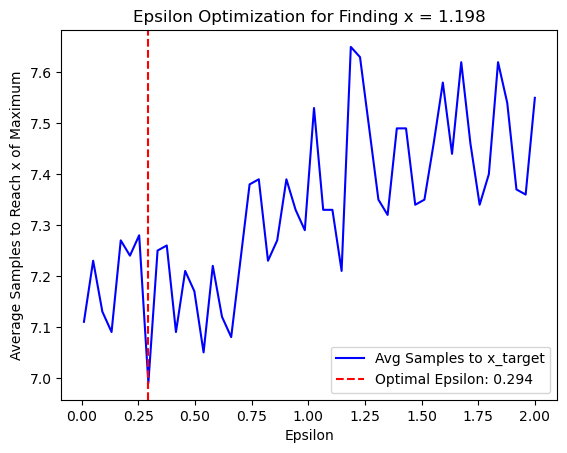

In [60]:
best_ep, avg_samples = optimize_acquisition1(ucb, xaxis, ground_truth, n_runs=100, 
                        epsilon_range=(.01,2), n_epsilons=50, n_iter=5, tolerance=0.015)

Running BO 10 times for EI with epsilon=0.058


/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_78706/1691904157.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)


Running BO 10 times for POI with epsilon=0.048
Running BO 10 times for UCB with epsilon=0.294


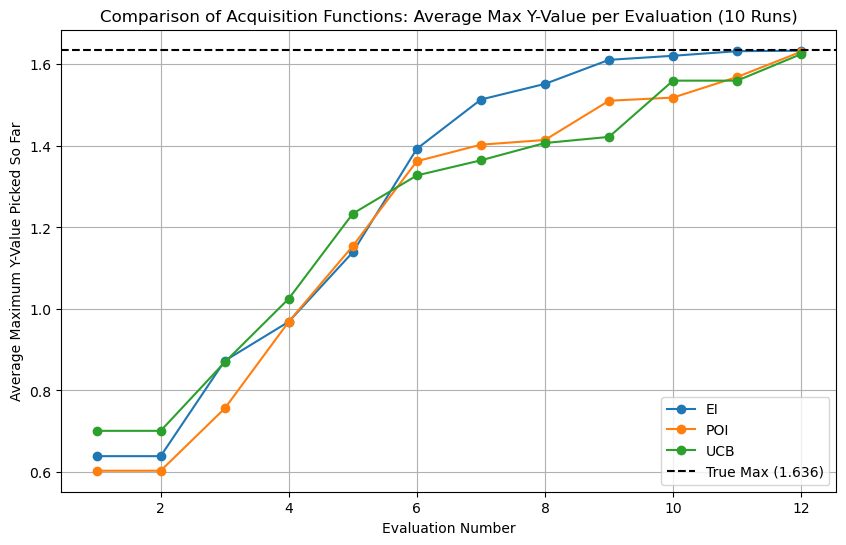

In [119]:
if __name__ == "__main__":
    xaxis = torch.linspace(0, 3, 1000)
    ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)
    
    optimized_epsilons = {
        'EI': (ei, 0.058),
        'POI': (poi, 0.0475),
        'UCB': (ucb, .294)
    }
    
    results = compare_acquisition_functions_ucb(
        acq_functions_with_epsilons=optimized_epsilons,
        xaxis=xaxis,
        ground_truth=ground_truth,
        n_runs=10,  # From your last run
        n_iter=10
    )

In [116]:
model= SurrogateModel(train_x, train_y, likelihood)

/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_78706/1458130641.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)  # Convert to tensor


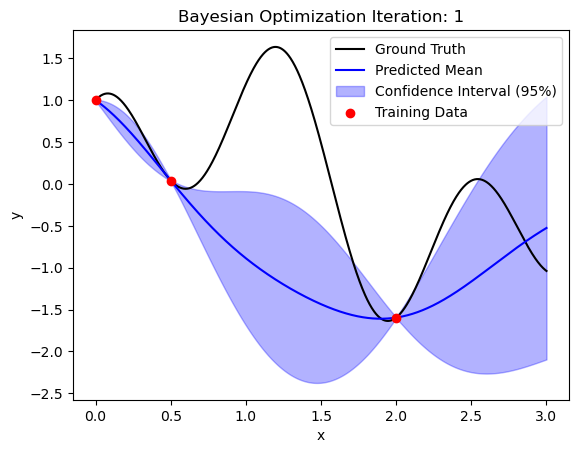

Iteration 1: train_x = [0.5 2.  0. ], train_y = [ 0.04032737 -1.5958741   1.        ]


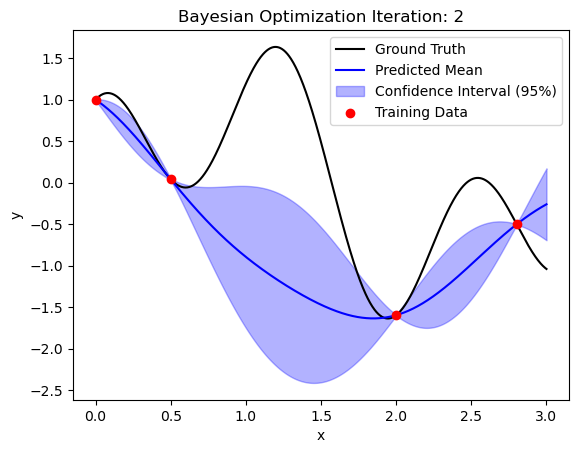

Iteration 2: train_x = [0.5       2.        0.        2.8018017], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994]


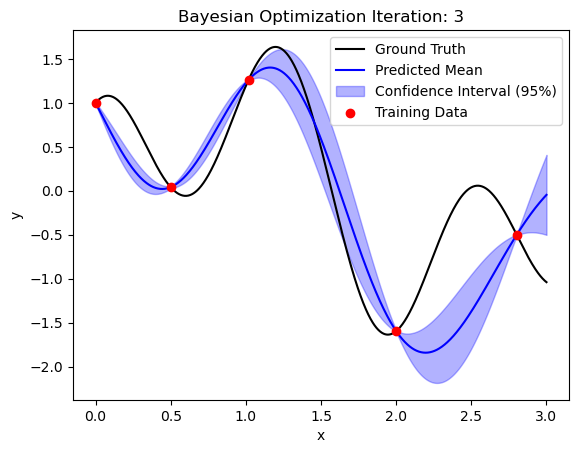

Iteration 3: train_x = [0.5       2.        0.        2.8018017 1.018018 ], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984 ]


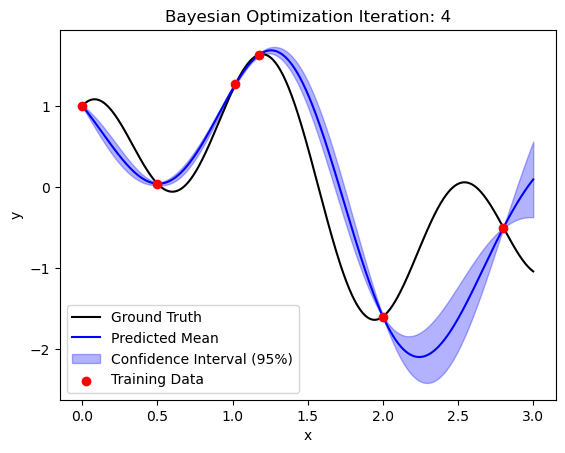

Iteration 4: train_x = [0.5       2.        0.        2.8018017 1.018018  1.1741742], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984   1.6288289 ]


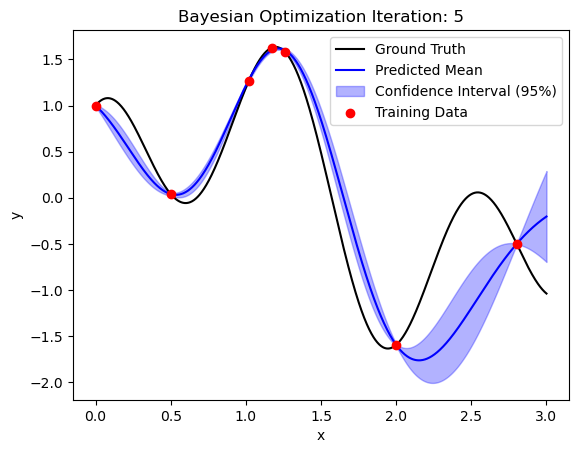

Iteration 5: train_x = [0.5       2.        0.        2.8018017 1.018018  1.1741742 1.2582583], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984   1.6288289
  1.585126  ]


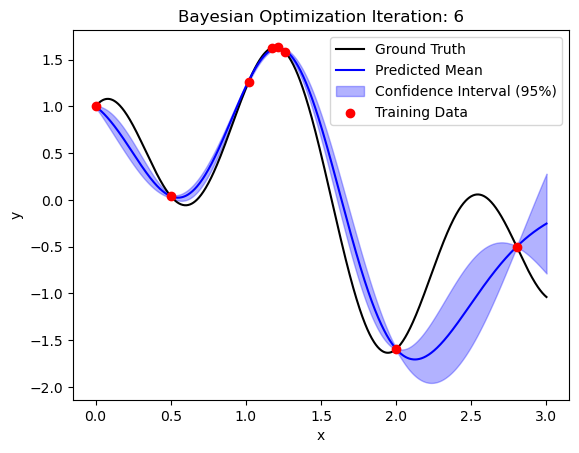

Iteration 6: train_x = [0.5       2.        0.        2.8018017 1.018018  1.1741742 1.2582583
 1.2162162], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984   1.6288289
  1.585126    1.630843  ]


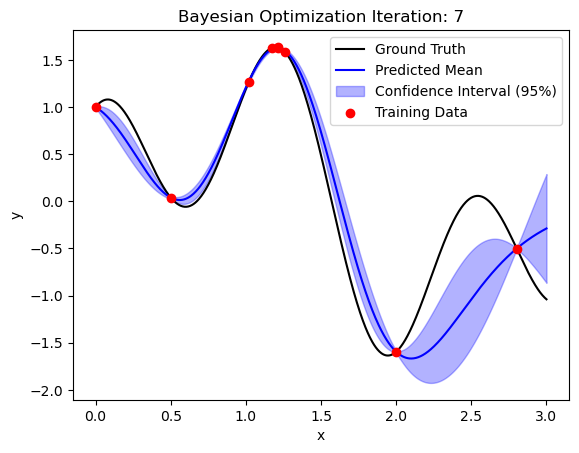

Iteration 7: train_x = [0.5       2.        0.        2.8018017 1.018018  1.1741742 1.2582583
 1.2162162 1.2132132], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984   1.6288289
  1.585126    1.630843    1.632265  ]


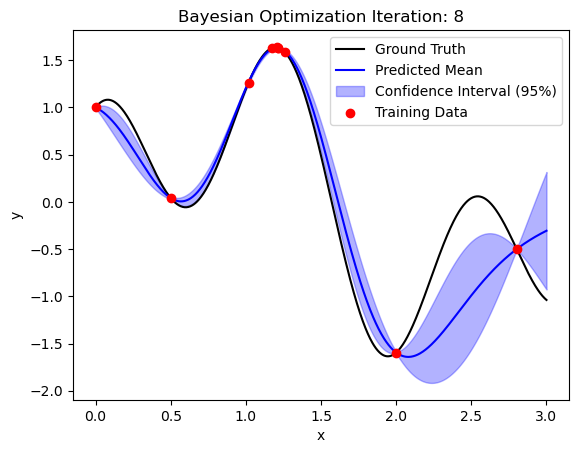

Iteration 8: train_x = [0.5       2.        0.        2.8018017 1.018018  1.1741742 1.2582583
 1.2162162 1.2132132 1.2102102], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984   1.6288289
  1.585126    1.630843    1.632265    1.6334431 ]


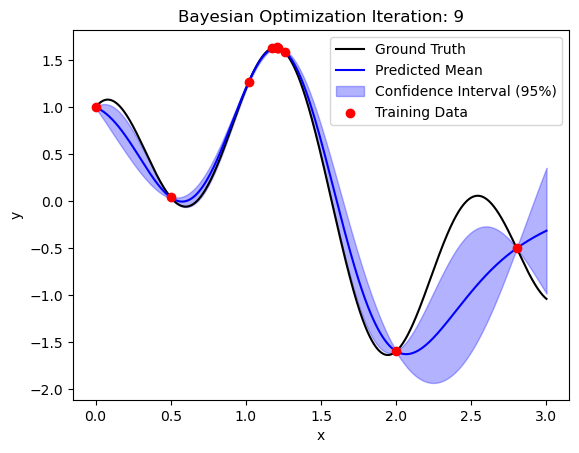

Iteration 9: train_x = [0.5       2.        0.        2.8018017 1.018018  1.1741742 1.2582583
 1.2162162 1.2132132 1.2102102 1.2042042], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984   1.6288289
  1.585126    1.630843    1.632265    1.6334431   1.6350703 ]


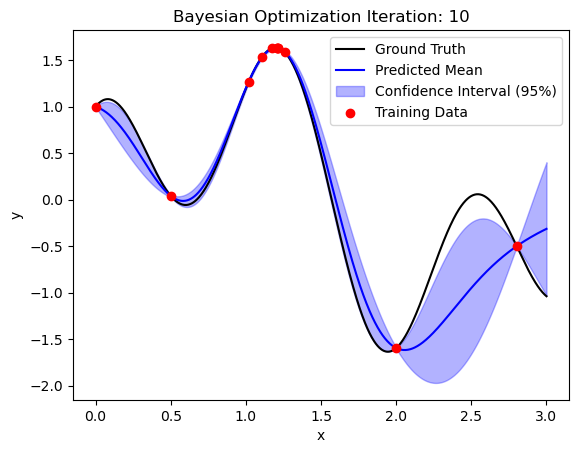

Iteration 10: train_x = [0.5       2.        0.        2.8018017 1.018018  1.1741742 1.2582583
 1.2162162 1.2132132 1.2102102 1.2042042 1.1081082], train_y = [ 0.04032737 -1.5958741   1.         -0.50065994  1.2624984   1.6288289
  1.585126    1.630843    1.632265    1.6334431   1.6350703   1.53553   ]


(tensor([0.5000, 2.0000, 0.0000, 2.8018, 1.0180, 1.1742, 1.2583, 1.2162, 1.2132,
         1.2102, 1.2042, 1.1081]),
 tensor([ 0.0403, -1.5959,  1.0000, -0.5007,  1.2625,  1.6288,  1.5851,  1.6308,
          1.6323,  1.6334,  1.6351,  1.5355]))

In [117]:
bayesian_optimization_ucb(model, xaxis, train_x, train_y, ucb, .294, 10)

/var/folders/gq/ysxmb7xx7d7_3hpwg1pcnx800000gn/T/ipykernel_78706/2481379912.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_sample = torch.tensor(next_sample, dtype=train_x.dtype)  # Convert to tensor


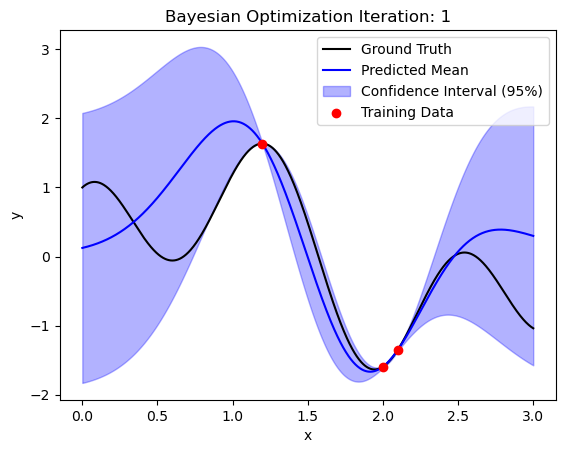

Iteration 1: train_x = [2.        2.1       1.1981982], train_y = [-1.5958741 -1.3471127  1.6357303]


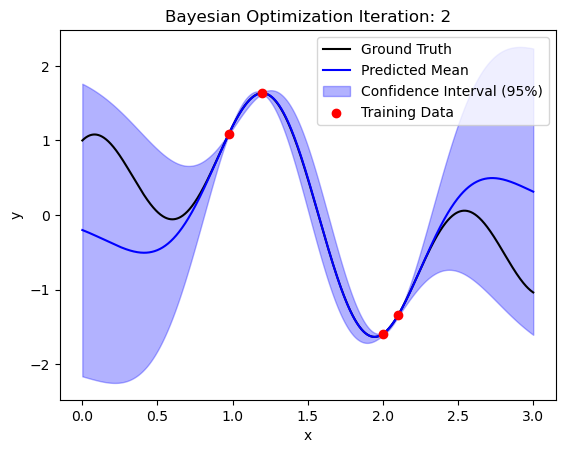

Iteration 2: train_x = [2.        2.1       1.1981982 0.972973 ], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386]


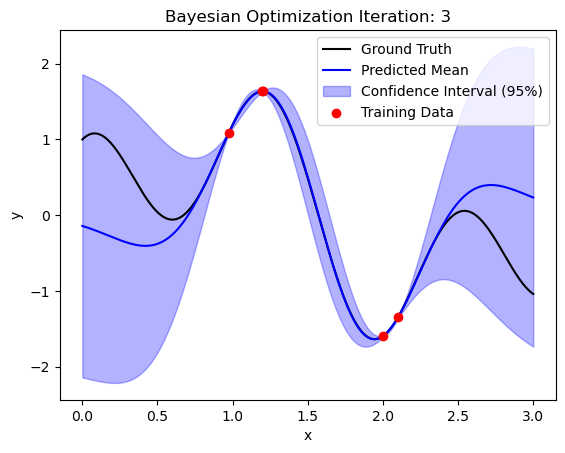

Iteration 3: train_x = [2.        2.1       1.1981982 0.972973  1.2012012], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386  1.6355209]


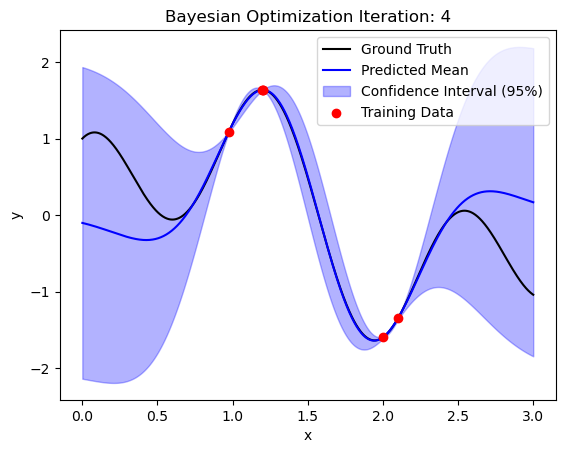

Iteration 4: train_x = [2.        2.1       1.1981982 0.972973  1.2012012 1.2042042], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386  1.6355209  1.6350703]


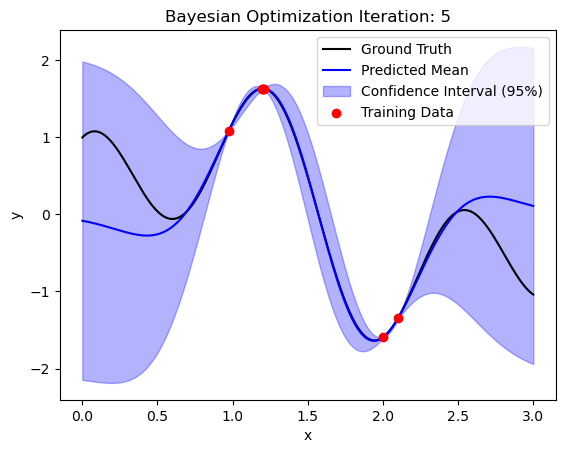

Iteration 5: train_x = [2.        2.1       1.1981982 0.972973  1.2012012 1.2042042 1.2072072], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386  1.6355209  1.6350703
  1.6343781]


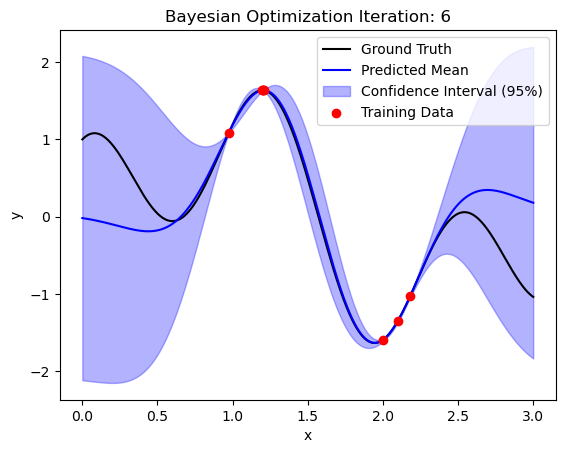

Iteration 6: train_x = [2.        2.1       1.1981982 0.972973  1.2012012 1.2042042 1.2072072
 2.18018  ], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386  1.6355209  1.6350703
  1.6343781 -1.0332081]


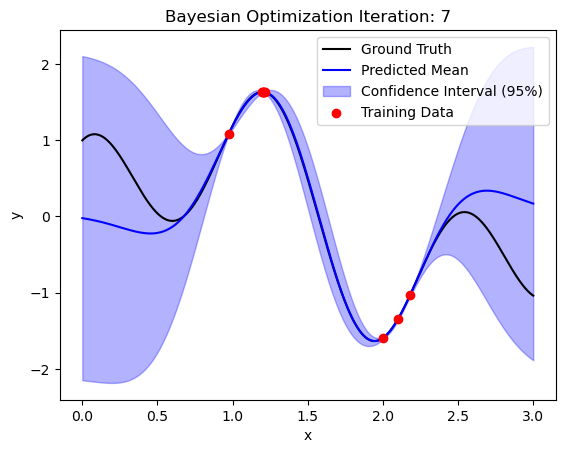

Iteration 7: train_x = [2.        2.1       1.1981982 0.972973  1.2012012 1.2042042 1.2072072
 2.18018   1.2162162], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386  1.6355209  1.6350703
  1.6343781 -1.0332081  1.630843 ]


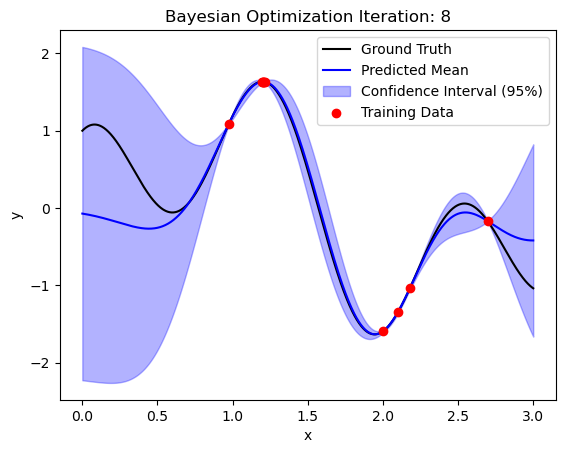

Iteration 8: train_x = [2.        2.1       1.1981982 0.972973  1.2012012 1.2042042 1.2072072
 2.18018   1.2162162 2.6966968], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386  1.6355209  1.6350703
  1.6343781 -1.0332081  1.630843  -0.1688267]


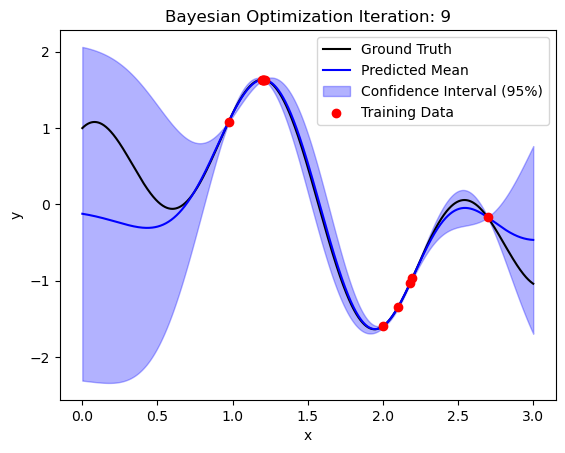

Iteration 9: train_x = [2.        2.1       1.1981982 0.972973  1.2012012 1.2042042 1.2072072
 2.18018   1.2162162 2.6966968 2.1951952], train_y = [-1.5958741 -1.3471127  1.6357303  1.0823386  1.6355209  1.6350703
  1.6343781 -1.0332081  1.630843  -0.1688267 -0.9682019]


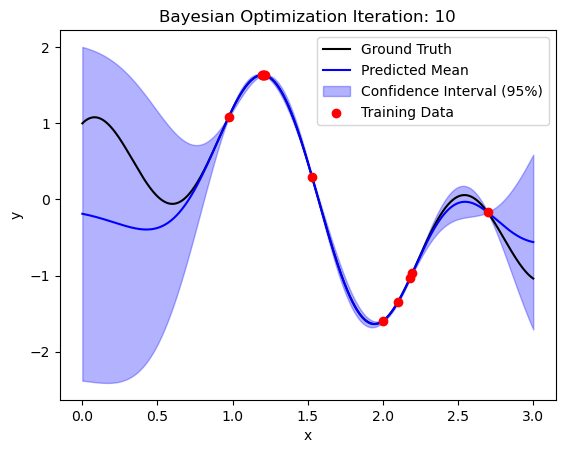

Iteration 10: train_x = [2.        2.1       1.1981982 0.972973  1.2012012 1.2042042 1.2072072
 2.18018   1.2162162 2.6966968 2.1951952 1.5285285], train_y = [-1.5958741  -1.3471127   1.6357303   1.0823386   1.6355209   1.6350703
  1.6343781  -1.0332081   1.630843   -0.1688267  -0.9682019   0.29420498]


(tensor([2.0000, 2.1000, 1.1982, 0.9730, 1.2012, 1.2042, 1.2072, 2.1802, 1.2162,
         2.6967, 2.1952, 1.5285]),
 tensor([-1.5959, -1.3471,  1.6357,  1.0823,  1.6355,  1.6351,  1.6344, -1.0332,
          1.6308, -0.1688, -0.9682,  0.2942]))

In [89]:
bayesian_optimization(model, xaxis, train_x, train_y, ucb, .294, 10)